## Dataset of chocolate ratings imported from http://flavorsofcacao.com/chocolate_database.html

Goals: 
* determine what factors are most important for predicting a high chocolate rating 
* generate a model that accurately predicts the rating of chocolate 

In [18]:
# Import all needed packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load csv file into a DataFrame 
df = pd.read_csv('flavors_of_cacao.csv')
#df = pd.read_csv("chocolate_ratings.csv")

# Check first 5 rows of DataFrame to make sure it loaded correctly 
df.head()


,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [19]:
# Rename some columns so they're easier to work with 
original_colnames = df.columns
new_colnames = ['company', 'species', 'REF', 'review_year', 'cocoa_percent',
                'company_location', 'rating', 'bean_typ', 'country']
df = df.rename(columns=dict(zip(original_colnames, new_colnames)))

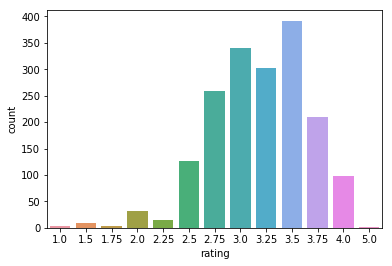

In [59]:
# What is the distribution of the ratings in our dataset? (our target feature)
sns.countplot(x='rating',data=df)

Distribution looks fairly normal, but is skewed towards higher ratings rather than being centered. 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
company             1795 non-null object
species             1795 non-null object
REF                 1795 non-null int64
review_year         1795 non-null int64
cocoa_percent       1795 non-null object
company_location    1795 non-null object
rating              1795 non-null float64
bean_typ            1794 non-null object
country             1794 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


Of our 8 columns, 6 are non-numerical. I will convert these into numerical values before proceeding to generate a model. 

In [21]:
# Remove unnessessary columns - Reference Number
"""Reference # indicates how recently the entry was added to the database. 
They are not unique values and are not important for analysis or prediction."""

df = df.drop(['REF'],axis=1)
df.head()

,company,species,review_year,cocoa_percent,company_location,rating,bean_typ,country
0,A. Morin,Agua Grande,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,2015,70%,France,3.50,,Peru


In [22]:
# modify data type to change the cocoa % from a string to a float
df['cocoa_percent'] = df['cocoa_percent'].str.replace('%','').astype(float)/100
df.head()

,company,species,review_year,cocoa_percent,company_location,rating,bean_typ,country
0,A. Morin,Agua Grande,2016,0.63,France,3.75,,Sao Tome
1,A. Morin,Kpime,2015,0.70,France,2.75,,Togo
2,A. Morin,Atsane,2015,0.70,France,3.00,,Togo
3,A. Morin,Akata,2015,0.70,France,3.50,,Togo
4,A. Morin,Quilla,2015,0.70,France,3.50,,Peru


I will next look at all the unique values in the company, species, company_location, and country columns to get an idea of how I want to engineer these categorical features into numerical data. 

In [26]:
print('company')
print(df['company'].nunique())
print('species')
print(df['species'].nunique())
print('company_location')
print(df['company_location'].nunique())
print('country')
print(df['country'].nunique())

company
416
species
1039
company_location
60
country
100


Hmm, of 1795 entries 1039 of these are unique species, 416 are unique companies, 100 are unique countries, and 60 have unique company locations. I will check to see if some of the unique values are actually repeats due to misspellings/abbreviations or combinations. 

In [27]:
set(df['country'])

{'Africa, Carribean, C. Am.',
 'Australia',
 'Belize',
 'Bolivia',
 'Brazil',
 'Burma',
 'Cameroon',
 'Carribean',
 'Carribean(DR/Jam/Tri)',
 'Central and S. America',
 'Colombia',
 'Colombia, Ecuador',
 'Congo',
 'Cost Rica, Ven',
 'Costa Rica',
 'Cuba',
 'DR, Ecuador, Peru',
 'Dom. Rep., Madagascar',
 'Domincan Republic',
 'Dominican Rep., Bali',
 'Dominican Republic',
 'Ecuador',
 'Ecuador, Costa Rica',
 'Ecuador, Mad., PNG',
 'El Salvador',
 'Fiji',
 'Gabon',
 'Ghana',
 'Ghana & Madagascar',
 'Ghana, Domin. Rep',
 'Ghana, Panama, Ecuador',
 'Gre., PNG, Haw., Haiti, Mad',
 'Grenada',
 'Guat., D.R., Peru, Mad., PNG',
 'Guatemala',
 'Haiti',
 'Hawaii',
 'Honduras',
 'India',
 'Indonesia',
 'Indonesia, Ghana',
 'Ivory Coast',
 'Jamaica',
 'Liberia',
 'Mad., Java, PNG',
 'Madagascar',
 'Madagascar & Ecuador',
 'Malaysia',
 'Martinique',
 'Mexico',
 'Nicaragua',
 'Nigeria',
 'PNG, Vanuatu, Mad',
 'Panama',
 'Papua New Guinea',
 'Peru',
 'Peru(SMartin,Pangoa,nacional)',
 'Peru, Belize',
 

Creating a dummy variable of each country should work for this - then combinations of countries will have several 1's within these dummy variables. Not sure how to do this though. 

In [58]:
#drop na values
no_country_df = df['country'].dropna()
#create a list containing unique country values 
all_countries = list(set(no_country_df))


In [57]:
# Filter out entries with a combination of countries 
combo = all_countries.str.contains(' ') 

# Perhaps use regex 

# Use this filtered list to create dummy variables 

AttributeError: 'list' object has no attribute 'str'